In [1]:
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys
sys.path.append("../")
from ad_utils import *
import warnings
warnings.filterwarnings('ignore')

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Few-Shot GAN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Attention mechanism for Few-Shot learning
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, attention_dim=64):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv1d(in_channels, attention_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(attention_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

# Enhanced Few-Shot Generator with Attention and Residual Connections
class EnhancedFewShotGenerator(nn.Module):
    def __init__(self, latent_dim=100, channels=14, seq_len=4500):
        super(EnhancedFewShotGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.seq_len = seq_len
        
        # Start with a smaller sequence length and upsample
        self.init_seq_len = seq_len // 32  # More aggressive downsampling
        
        # Enhanced initial projection with batch normalization
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_seq_len),
            nn.BatchNorm1d(256 * self.init_seq_len),
            nn.ReLU(inplace=True)
        )
        
        # Progressive upsampling with attention and residual connections
        self.conv_blocks = nn.ModuleList([
            # Block 1: 256 -> 128 channels
            nn.Sequential(
                nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                AttentionBlock(128)
            ),
            # Block 2: 128 -> 64 channels  
            nn.Sequential(
                nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                AttentionBlock(64)
            ),
            # Block 3: 64 -> 32 channels
            nn.Sequential(
                nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),
            ),
            # Block 4: 32 -> 16 channels
            nn.Sequential(
                nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(16),
                nn.ReLU(inplace=True),
            ),
            # Final block: 16 -> channels
            nn.Sequential(
                nn.ConvTranspose1d(16, channels, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
            )
        ])

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_seq_len)
        
        # Progressive upsampling with skip connections
        for i, block in enumerate(self.conv_blocks):
            out = block(out)
        
        # Ensure exact sequence length through interpolation if needed
        if out.size(2) != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        return out  # Shape: (batch, 14, 4500)

# Enhanced Few-Shot Discriminator with Multi-Scale Features
class EnhancedFewShotDiscriminator(nn.Module):
    def __init__(self, channels=14, seq_len=4500):
        super(EnhancedFewShotDiscriminator, self).__init__()
        
        # Multi-scale feature extraction
        self.scale1_conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(channels, 32, kernel_size=3, stride=1, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.scale2_conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(channels, 32, kernel_size=7, stride=1, padding=3)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Feature fusion
        self.fusion = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )
        
        # Further processing
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.utils.spectral_norm(nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Multi-scale feature extraction
        scale1_features = self.scale1_conv(x)
        scale2_features = self.scale2_conv(x)
        
        # Concatenate multi-scale features
        multi_scale_features = torch.cat([scale1_features, scale2_features], dim=1)
        
        # Fusion and classification
        fused_features = self.fusion(multi_scale_features)
        output = self.model(fused_features)
        
        return output

class FewShot1DDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        """
        Args:
            data: numpy array of shape [n_samples, 4500, 14]
            labels: numpy array of shape [n_samples] (optional)
        """
        # Transpose to (n_samples, 14, 4500) for Conv1d
        self.data = torch.tensor(data.transpose(0, 2, 1), dtype=torch.float32)
        
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]  # Shape: (14, 4500)
        
        if self.transform:
            sample = self.transform(sample)
            
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return sample, label
        return sample, 0

# Enhanced training function with few-shot learning capabilities
def train_enhanced_few_shot_gan(normal_data, device, epochs=100, batch_size=32, lr_g=1e-4, lr_d=2e-4):
    """
    Enhanced Few-Shot GAN training with improved stability and attention mechanisms
    """
    print(f"Training Enhanced Few-Shot GAN on data shape: {normal_data.shape}")
    
    # Data loading
    dataset = FewShot1DDataset(normal_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Initialize enhanced models
    latent_dim = 100
    num_channels = normal_data.shape[-1]
    seq_length = normal_data.shape[1]
    
    generator = EnhancedFewShotGenerator(latent_dim=latent_dim, channels=num_channels, seq_len=seq_length).to(device)
    discriminator = EnhancedFewShotDiscriminator(channels=num_channels, seq_len=seq_length).to(device)

    # Xavier/He initialization for better stability
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            nn.init.xavier_normal_(m.weight, gain=0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

    generator.apply(init_weights)
    discriminator.apply(init_weights)

    # Optimizers with different learning rates for stability
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, patience=20, factor=0.8)
    scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, patience=20, factor=0.8)

    # Enhanced loss function with label smoothing
    def adversarial_loss_smooth(pred, target_is_real, smoothing=0.1):
        if target_is_real:
            target = torch.ones_like(pred) * (1.0 - smoothing) + smoothing * torch.rand_like(pred)
        else:
            target = torch.zeros_like(pred) + smoothing * torch.rand_like(pred)
        return nn.BCELoss()(pred, target)

    # Training history
    g_losses, d_losses = [], []
    
    print("Starting Enhanced Few-Shot GAN training...")
    print(f"Generator LR: {lr_g}, Discriminator LR: {lr_d}")

    for epoch in range(epochs):
        epoch_g_loss, epoch_d_loss = 0, 0
        
        for i, (real_samples, _) in enumerate(dataloader):
            real_samples = real_samples.to(device)  # Shape: (batch, 14, 4500)
            batch_size_actual = real_samples.size(0)
            
            # Add noise to real samples for robustness
            noisy_real = real_samples + 0.05 * torch.randn_like(real_samples)
            
            # ========================
            # Train Discriminator
            # ========================
            optimizer_D.zero_grad()
            
            # Real samples
            real_pred = discriminator(noisy_real)
            d_real_loss = adversarial_loss_smooth(real_pred, True)
            
            # Fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z).detach()
            fake_pred = discriminator(fake_samples)
            d_fake_loss = adversarial_loss_smooth(fake_pred, False)
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)
            optimizer_D.step()
            
            # ========================
            # Train Generator
            # ========================
            optimizer_G.zero_grad()
            
            # Generate fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z)
            fake_pred = discriminator(fake_samples)
            
            # Generator loss (want discriminator to classify fake as real)
            g_loss = adversarial_loss_smooth(fake_pred, True)
            g_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 0.5)
            optimizer_G.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            if i % 50 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Store average losses per epoch
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_d_loss = epoch_d_loss / len(dataloader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        # Update learning rates
        scheduler_G.step(avg_g_loss)
        scheduler_D.step(avg_d_loss)

        # Enhanced stability monitoring
        if epoch % 10 == 0:
            monitor_gan_stability(g_losses, d_losses, window=10)
    
    print("Enhanced Few-Shot GAN training completed!")
    return generator, discriminator, g_losses, d_losses

def generate_samples(generator, num_samples, latent_dim=100):
    """
    Generate samples using the trained generator
    Returns data in shape (num_samples, 4500, 14)
    """
    device = next(generator.parameters()).device
    generator.eval()
    
    batch_size = 16
    all_samples = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            z = torch.randn(current_batch_size, latent_dim, device=device)
            batch_samples = generator(z)  # Shape: (batch, 14, 4500)
            all_samples.append(batch_samples.cpu())
    
    generated_data = torch.cat(all_samples, dim=0).numpy()
    
    # Transpose back to (n_samples, 4500, 14)
    generated_data = generated_data.transpose(0, 2, 1)
    
    return generated_data

# Enhanced monitoring with more detailed analysis
def monitor_gan_stability(g_losses, d_losses, window=10):
    """
    Enhanced GAN training stability monitoring
    """
    if len(g_losses) < window:
        return
    
    # Recent losses
    recent_g = np.mean(g_losses[-window:])
    recent_d = np.mean(d_losses[-window:])
    
    # Loss ratio (should be roughly balanced)
    ratio = recent_g / (recent_d + 1e-8)
    
    # Loss variance (should be stable, not oscillating wildly)
    g_var = np.var(g_losses[-window:])
    d_var = np.var(d_losses[-window:])
    
    # Loss trend analysis
    if len(g_losses) >= window * 2:
        g_trend = np.mean(g_losses[-window:]) - np.mean(g_losses[-window*2:-window])
        d_trend = np.mean(d_losses[-window:]) - np.mean(d_losses[-window*2:-window])
    else:
        g_trend = d_trend = 0
    
    print(f"G/D Ratio: {ratio:.3f} | G_var: {g_var:.4f} | D_var: {d_var:.4f}")
    print(f"G_trend: {g_trend:+.4f} | D_trend: {d_trend:+.4f}")
    
    # Enhanced stability warnings
    if ratio > 5:
        print("⚠️  Generator significantly overpowering Discriminator")
        print("   💡 Consider: Lower G learning rate or train D more frequently")
    elif ratio < 0.2:
        print("⚠️  Discriminator significantly overpowering Generator")
        print("   💡 Consider: Lower D learning rate or add noise to real data")
    elif g_var > 1.0 or d_var > 1.0:
        print("⚠️  High variance - unstable training detected")
        print("   💡 Consider: Lower learning rates or gradient clipping")
    elif abs(g_trend) > 0.5 or abs(d_trend) > 0.5:
        print("⚠️  Significant loss trends detected")
        print("   💡 Consider: Learning rate scheduling or early stopping")
    else:
        print("✅ Training appears stable and balanced")

# Enhanced visualization
def plot_enhanced_training_curves(g_losses, d_losses):
    """
    Plot enhanced training curves with additional analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(g_losses, label='Generator Loss', alpha=0.7)
    axes[0, 0].plot(d_losses, label='Discriminator Loss', alpha=0.7)
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss ratio
    ratios = [g/(d+1e-8) for g, d in zip(g_losses, d_losses)]
    axes[0, 1].plot(ratios, color='green', alpha=0.7)
    axes[0, 1].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Ideal Ratio')
    axes[0, 1].set_title('Generator/Discriminator Loss Ratio')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('G_loss / D_loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Moving averages
    window = 10
    if len(g_losses) >= window:
        g_ma = pd.Series(g_losses).rolling(window=window).mean()
        d_ma = pd.Series(d_losses).rolling(window=window).mean()
        
        axes[1, 0].plot(g_ma, label=f'Generator MA({window})', alpha=0.7)
        axes[1, 0].plot(d_ma, label=f'Discriminator MA({window})', alpha=0.7)
        axes[1, 0].set_title('Moving Average Losses')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Loss variance
    if len(g_losses) >= window:
        g_var = pd.Series(g_losses).rolling(window=window).var()
        d_var = pd.Series(d_losses).rolling(window=window).var()
        
        axes[1, 1].plot(g_var, label=f'Generator Var({window})', alpha=0.7)
        axes[1, 1].plot(d_var, label=f'Discriminator Var({window})', alpha=0.7)
        axes[1, 1].set_title('Loss Variance (Stability Indicator)')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Variance')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Few-Shot GAN Training

In [3]:

class SelfAttention1D(nn.Module):
    """Self-attention module optimized for time series"""
    def __init__(self, in_channels):
        super(SelfAttention1D, self).__init__()
        self.in_channels = in_channels
        self.query = nn.Conv1d(in_channels, in_channels // 4, 1)  # Reduced for efficiency
        self.key = nn.Conv1d(in_channels, in_channels // 4, 1)
        self.value = nn.Conv1d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, channels, length = x.size()
        
        # Subsample for long sequences to reduce computation
        if length > 1000:
            step = length // 500
            x_sub = x[:, :, ::step]
        else:
            x_sub = x
            
        sub_length = x_sub.size(2)
        
        # Generate query, key, value on subsampled data
        q = self.query(x_sub).view(batch_size, -1, sub_length).permute(0, 2, 1)
        k = self.key(x_sub).view(batch_size, -1, sub_length)
        v = self.value(x_sub).view(batch_size, -1, sub_length)
        
        # Attention calculation
        attention = torch.bmm(q, k)
        attention = self.softmax(attention)
        
        # Apply attention to values
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, sub_length)
        
        # Interpolate back to original length if subsampled
        if length > 1000:
            out = nn.functional.interpolate(out, size=length, mode='linear', align_corners=False)
        
        return self.gamma * out + x

class ResidualBlock1D(nn.Module):
    """Optimized residual block for sensor data"""
    def __init__(self, channels):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, 5, padding=2)  # Larger kernel for temporal patterns
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        return F.relu(out + residual)

class ImprovedFewShotGenerator(nn.Module):
    """Enhanced generator optimized for sensor time series"""
    def __init__(self, latent_dim=100, output_channels=14, target_length=4500):
        super(ImprovedFewShotGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.output_channels = output_channels
        self.target_length = target_length
        
        # Optimized initial projection for 4500 length
        self.initial_length = 141  # 141 * 32 = 4512 ≈ 4500
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * self.initial_length),
            nn.BatchNorm1d(512 * self.initial_length),
            nn.ReLU(True)
        )
        
        # Progressive upsampling optimized for sensor data
        self.upsample_blocks = nn.ModuleList([
            # 141 -> 282
            nn.Sequential(
                nn.ConvTranspose1d(512, 256, 4, stride=2, padding=1),
                nn.BatchNorm1d(256),
                nn.ReLU(True),
                ResidualBlock1D(256)
            ),
            # 282 -> 564  
            nn.Sequential(
                nn.ConvTranspose1d(256, 128, 4, stride=2, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(True),
                ResidualBlock1D(128)
            ),
            # 564 -> 1128
            nn.Sequential(
                nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(True),
                ResidualBlock1D(64)
            ),
            # 1128 -> 2256
            nn.Sequential(
                nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1),
                nn.BatchNorm1d(32),
                nn.ReLU(True),
                ResidualBlock1D(32)
            ),
            # 2256 -> 4512
            nn.Sequential(
                nn.ConvTranspose1d(32, 16, 4, stride=2, padding=1),
                nn.BatchNorm1d(16),
                nn.ReLU(True),
            ),
        ])
        
        # Attention for long-range temporal dependencies
        self.attention = SelfAttention1D(16)
        
        # Final layers for sensor-specific patterns
        self.final_layers = nn.Sequential(
            nn.Conv1d(16, output_channels, 7, padding=3),  # Larger kernel for temporal smoothness
            nn.Tanh()
        )
        
    def forward(self, z):
        # Project latent vector
        x = self.fc(z)
        x = x.view(z.size(0), 512, self.initial_length)
        
        # Progressive upsampling
        for upsample_block in self.upsample_blocks:
            x = upsample_block(x)
        
        # Apply attention for temporal coherence
        x = self.attention(x)
        
        # Final transformation
        x = self.final_layers(x)
        
        # Precise length adjustment for 4500
        current_length = x.size(-1)
        if current_length > self.target_length:
            start_idx = (current_length - self.target_length) // 2
            x = x[:, :, start_idx:start_idx + self.target_length]
        elif current_length < self.target_length:
            pad_left = (self.target_length - current_length) // 2
            pad_right = self.target_length - current_length - pad_left
            x = F.pad(x, (pad_left, pad_right), mode='reflect')
        
        return x

class ImprovedFewShotDiscriminator(nn.Module):
    """Enhanced discriminator optimized for sensor time series"""
    def __init__(self, input_channels=14):
        super(ImprovedFewShotDiscriminator, self).__init__()
        
        # Multi-scale feature extraction for different temporal patterns
        self.conv_blocks = nn.ModuleList([
            # 4500 -> 2250
            nn.Sequential(
                nn.utils.spectral_norm(nn.Conv1d(input_channels, 64, 8, stride=2, padding=3)),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.1)
            ),
            # 2250 -> 1125
            nn.Sequential(
                nn.utils.spectral_norm(nn.Conv1d(64, 128, 8, stride=2, padding=3)),
                nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.1)
            ),
            # 1125 -> 562
            nn.Sequential(
                nn.utils.spectral_norm(nn.Conv1d(128, 256, 8, stride=2, padding=3)),
                nn.BatchNorm1d(256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2)
            ),
            # 562 -> 281
            nn.Sequential(
                nn.utils.spectral_norm(nn.Conv1d(256, 512, 8, stride=2, padding=3)),
                nn.BatchNorm1d(512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2)
            ),
            # 281 -> 140
            nn.Sequential(
                nn.utils.spectral_norm(nn.Conv1d(512, 512, 8, stride=2, padding=3)),
                nn.BatchNorm1d(512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.3)
            )
        ])
        
        # Optimized attention for sensor patterns
        self.attention = SelfAttention1D(512)
        
        # Enhanced classifier for better discrimination
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.utils.spectral_norm(nn.Linear(256, 64)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.utils.spectral_norm(nn.Linear(64, 1)),
            nn.Sigmoid()
        )
    
    def forward(self, x, return_features=False):
        features = []
        
        # Progressive feature extraction
        for conv_block in self.conv_blocks:
            x = conv_block(x)
            if return_features:
                features.append(x)
        
        # Apply attention for important temporal patterns
        x = self.attention(x)
        if return_features:
            features.append(x)
        
        # Final classification
        output = self.classifier(x)
        
        if return_features:
            return output, features
        return output

def feature_matching_loss(real_features, fake_features):
    """Enhanced feature matching loss with temporal weighting"""
    loss = 0
    weights = [1.0, 1.5, 2.0, 2.5, 3.0, 1.0]  # Higher weight for middle layers
    
    for i, (real_feat, fake_feat) in enumerate(zip(real_features, fake_features)):
        weight = weights[i] if i < len(weights) else 1.0
        # Use both mean and variance matching for better distribution alignment
        mean_loss = nn.MSELoss()(fake_feat.mean(0), real_feat.mean(0))
        var_loss = nn.MSELoss()(fake_feat.var(0), real_feat.var(0))
        loss += weight * (mean_loss + 0.5 * var_loss)
    return loss

def gradient_penalty(discriminator, real_samples, fake_samples, device, lambda_gp=10.0):
    """Optimized gradient penalty for sensor data"""
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1).expand_as(real_samples).to(device)
    
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated.requires_grad_(True)
    
    d_interpolated = discriminator(interpolated)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return lambda_gp * gradient_penalty

def train_improved_few_shot_gan(X_train, epochs=200, batch_size=16, latent_dim=128, 
                               lr_g=0.0002, lr_d=0.0001, device='cuda'):  # Reduced learning rates
    """
    Optimized training for sensor time series with better FID score
    """
    print("🚀 Starting Optimized Few-Shot GAN Training for Sensor Data")
    print("=" * 60)
    
    # Data loading with optimized batch size
    dataset = FewShot1DDataset(X_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Initialize optimized models
    generator = ImprovedFewShotGenerator(latent_dim=latent_dim).to(device)
    discriminator = ImprovedFewShotDiscriminator().to(device)
    
    # Balanced optimizers for sensor data - FIXED learning rates
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    adversarial_loss = nn.BCELoss()
    
    # Training tracking
    g_losses, d_losses = [], []
    feature_losses, gp_losses = [], []
    
    print(f"📊 Optimized Configuration:")
    print(f"   • Latent Dimension: {latent_dim}")
    print(f"   • Batch Size: {batch_size}")
    print(f"   • Learning Rates: G={lr_g}, D={lr_d}")
    print("=" * 60)
    
    for epoch in range(epochs):
        epoch_g_loss, epoch_d_loss = 0, 0
        epoch_feature_loss, epoch_gp_loss = 0, 0
        
        for i, (real_samples, _) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_current = real_samples.size(0)
            
            # ========================
            # Balanced Discriminator Training - REDUCED FREQUENCY
            # ========================
            if i % 2 == 0:  # Train discriminator every 2 iterations
                optimizer_D.zero_grad()
                
                # Real samples with STRONGER label smoothing
                real_labels = torch.ones(batch_size_current, 1, device=device) * (0.8 + 0.15 * torch.rand(batch_size_current, 1, device=device))
                real_pred = discriminator(real_samples)
                real_loss = adversarial_loss(real_pred, real_labels)
                
                # Fake samples
                z = torch.randn(batch_size_current, latent_dim, device=device)
                fake_samples = generator(z).detach()
                fake_labels = torch.zeros(batch_size_current, 1, device=device) + 0.2 * torch.rand(batch_size_current, 1, device=device)
                fake_pred = discriminator(fake_samples)
                fake_loss = adversarial_loss(fake_pred, fake_labels)
                
                # REDUCED gradient penalty
                gp = gradient_penalty(discriminator, real_samples, fake_samples, device, lambda_gp=2.0)  # Reduced from 5.0
                
                # Total discriminator loss
                d_loss = real_loss + fake_loss + gp
                d_loss.backward()
                
                # Stronger gradient clipping
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)  # Reduced from 1.0
                optimizer_D.step()
                
                epoch_d_loss += (real_loss.item() + fake_loss.item()) / 2
                epoch_gp_loss += gp.item()
            
            # ========================
            # Enhanced Generator Training - EVERY ITERATION
            # ========================
            optimizer_G.zero_grad()
            
            # Generate fake samples
            z = torch.randn(batch_size_current, latent_dim, device=device)
            fake_samples = generator(z)
            
            # Get predictions and features
            fake_pred, fake_features = discriminator(fake_samples, return_features=True)
            _, real_features = discriminator(real_samples, return_features=True)
            
            # Adversarial loss
            valid_labels = torch.ones(batch_size_current, 1, device=device)
            adv_loss = adversarial_loss(fake_pred, valid_labels)
            
            # Enhanced feature matching loss
            fm_loss = feature_matching_loss(real_features, fake_features)
            
            # REDUCED feature matching weight
            g_loss = adv_loss + 5.0 * fm_loss  # Reduced from 15.0
            g_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 0.5)  # Reduced from 1.0
            optimizer_G.step()
            
            epoch_g_loss += adv_loss.item()
            epoch_feature_loss += fm_loss.item()
            
            if i % 50 == 0:
                print(f"[Epoch {epoch+1:3d}/{epochs}] [Batch {i:3d}/{len(dataloader)}] "
                      f"[D: {d_loss.item() if i % 2 == 0 else 'skipped':.4f}] [G: {adv_loss.item():.4f}] "
                      f"[FM: {fm_loss.item():.4f}] [GP: {gp.item() if i % 2 == 0 else 'skipped':.4f}]")
        
        # Store average losses per epoch
        g_losses.append(epoch_g_loss / len(dataloader))
        d_losses.append(epoch_d_loss / (len(dataloader) // 2))  # Adjusted for reduced D training
        feature_losses.append(epoch_feature_loss / len(dataloader))
        gp_losses.append(epoch_gp_loss / (len(dataloader) // 2))  # Adjusted for reduced D training
        
        # Enhanced monitoring every 20 epochs
        if epoch % 20 == 0:
            print(f"\n{'='*15} Epoch {epoch+1} Summary {'='*15}")
            print(f"📈 Avg Generator Loss: {g_losses[-1]:.4f}")
            print(f"📉 Avg Discriminator Loss: {d_losses[-1]:.4f}")
            print(f"🎯 Avg Feature Matching Loss: {feature_losses[-1]:.4f}")
            print(f"⚖️  Avg Gradient Penalty: {gp_losses[-1]:.4f}")
            
            # Generate samples for quality check
            with torch.no_grad():
                z_test = torch.randn(32, latent_dim, device=device)
                test_samples = generator(z_test)
                
                # Basic quality metrics
                sample_mean = test_samples.mean().item()
                sample_std = test_samples.std().item()
                sample_range = (test_samples.max() - test_samples.min()).item()
                
                print(f"📊 Generated Sample Stats:")
                print(f"   • Mean: {sample_mean:.4f}")
                print(f"   • Std: {sample_std:.4f}")
                print(f"   • Range: {sample_range:.4f}")
            
            print("=" * 50)
    
    return generator, discriminator, g_losses, d_losses, feature_losses, gp_losses

# def train_improved_few_shot_gan(X_train, epochs=200, batch_size=16, latent_dim=128, 
#                                lr_g=0.0002, lr_d=0.0001, device='cuda'):  # Reduced learning rates
#     """
#     Optimized training for sensor time series with better FID score
#     """
#     print("🚀 Starting Optimized Few-Shot GAN Training for Sensor Data")
#     print("=" * 60)
    
#     # Data loading with optimized batch size
#     dataset = FewShot1DDataset(X_train)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
#     # Initialize optimized models
#     generator = ImprovedFewShotGenerator(latent_dim=latent_dim).to(device)
#     discriminator = ImprovedFewShotDiscriminator().to(device)
    
#     # Balanced optimizers for sensor data - FIXED learning rates
#     optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
#     optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
#     # Loss function
#     adversarial_loss = nn.BCELoss()
    
#     # Training tracking
#     g_losses, d_losses = [], []
#     feature_losses, gp_losses = [], []
    
#     print(f"📊 Optimized Configuration:")
#     print(f"   • Latent Dimension: {latent_dim}")
#     print(f"   • Batch Size: {batch_size}")
#     print(f"   • Learning Rates: G={lr_g}, D={lr_d}")
#     print("=" * 60)
    
#     for epoch in range(epochs):
#         epoch_g_loss, epoch_d_loss = 0, 0
#         epoch_feature_loss, epoch_gp_loss = 0, 0
        
#         for i, (real_samples, _) in enumerate(dataloader):
#             real_samples = real_samples.to(device)
#             batch_size_current = real_samples.size(0)
            
#             # ========================
#             # Balanced Discriminator Training - REDUCED FREQUENCY
#             # ========================
#             if i % 2 == 0:  # Train discriminator every 2 iterations
#                 optimizer_D.zero_grad()
                
#                 # Real samples with STRONGER label smoothing
#                 real_labels = torch.ones(batch_size_current, 1, device=device) * (0.8 + 0.15 * torch.rand(batch_size_current, 1, device=device))
#                 real_pred = discriminator(real_samples)
#                 real_loss = adversarial_loss(real_pred, real_labels)
                
#                 # Fake samples
#                 z = torch.randn(batch_size_current, latent_dim, device=device)
#                 fake_samples = generator(z).detach()
#                 fake_labels = torch.zeros(batch_size_current, 1, device=device) + 0.2 * torch.rand(batch_size_current, 1, device=device)
#                 fake_pred = discriminator(fake_samples)
#                 fake_loss = adversarial_loss(fake_pred, fake_labels)
                
#                 # REDUCED gradient penalty
#                 gp = gradient_penalty(discriminator, real_samples, fake_samples, device, lambda_gp=2.0)  # Reduced from 5.0
                
#                 # Total discriminator loss
#                 d_loss = real_loss + fake_loss + gp
#                 d_loss.backward()
                
#                 # Stronger gradient clipping
#                 torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)  # Reduced from 1.0
#                 optimizer_D.step()
                
#                 epoch_d_loss += (real_loss.item() + fake_loss.item()) / 2
#                 epoch_gp_loss += gp.item()
            
#             # ========================
#             # Enhanced Generator Training - EVERY ITERATION
#             # ========================
#             optimizer_G.zero_grad()
            
#             # Generate fake samples
#             z = torch.randn(batch_size_current, latent_dim, device=device)
#             fake_samples = generator(z)
            
#             # Get predictions and features
#             fake_pred, fake_features = discriminator(fake_samples, return_features=True)
#             _, real_features = discriminator(real_samples, return_features=True)
            
#             # Adversarial loss
#             valid_labels = torch.ones(batch_size_current, 1, device=device)
#             adv_loss = adversarial_loss(fake_pred, valid_labels)
            
#             # Enhanced feature matching loss
#             fm_loss = feature_matching_loss(real_features, fake_features)
            
#             # REDUCED feature matching weight
#             g_loss = adv_loss + 5.0 * fm_loss  # Reduced from 15.0
#             g_loss.backward()
            
#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(generator.parameters(), 0.5)  # Reduced from 1.0
#             optimizer_G.step()
            
#             epoch_g_loss += adv_loss.item()
#             epoch_feature_loss += fm_loss.item()
            
#             if i % 50 == 0:
#                 print(f"[Epoch {epoch+1:3d}/{epochs}] [Batch {i:3d}/{len(dataloader)}] "
#                       f"[D: {d_loss.item() if i % 2 == 0 else 'skipped':.4f}] [G: {adv_loss.item():.4f}] "
#                       f"[FM: {fm_loss.item():.4f}] [GP: {gp.item() if i % 2 == 0 else 'skipped':.4f}]")
        
#         # Store average losses per epoch
#         g_losses.append(epoch_g_loss / len(dataloader))
#         d_losses.append(epoch_d_loss / (len(dataloader) // 2))  # Adjusted for reduced D training
#         feature_losses.append(epoch_feature_loss / len(dataloader))
#         gp_losses.append(epoch_gp_loss / (len(dataloader) // 2))  # Adjusted for reduced D training
        
#         # Enhanced monitoring every 20 epochs
#         if epoch % 20 == 0:
#             print(f"\n{'='*15} Epoch {epoch+1} Summary {'='*15}")
#             print(f"📈 Avg Generator Loss: {g_losses[-1]:.4f}")
#             print(f"📉 Avg Discriminator Loss: {d_losses[-1]:.4f}")
#             print(f"🎯 Avg Feature Matching Loss: {feature_losses[-1]:.4f}")
#             print(f"⚖️  Avg Gradient Penalty: {gp_losses[-1]:.4f}")
            
#             # Generate samples for quality check
#             with torch.no_grad():
#                 z_test = torch.randn(32, latent_dim, device=device)
#                 test_samples = generator(z_test)
                
#                 # Basic quality metrics
#                 sample_mean = test_samples.mean().item()
#                 sample_std = test_samples.std().item()
#                 sample_range = (test_samples.max() - test_samples.min()).item()
                
#                 print(f"📊 Generated Sample Stats:")
#                 print(f"   • Mean: {sample_mean:.4f}")
#                 print(f"   • Std: {sample_std:.4f}")
#                 print(f"   • Range: {sample_range:.4f}")
            
#             print("=" * 50)
    
#     return generator, discriminator, g_losses, d_losses, feature_losses, gp_losses

# Generate and Combine

In [4]:
# Train with optimized parameters for better FID score
generator, discriminator, g_loss, d_loss, feature_loss, gp_loss = train_improved_few_shot_gan(
    X_train_normal, 
    epochs=200, 
    batch_size=16,      # Reduced from 32 for better stability
    latent_dim=128,
    lr_g=0.0002,        # Reduced from 0.0003
    lr_d=0.0001,        # Keep same
    device=device
)

# Generate samples with correct function
generated_data = generate_samples(generator, len(X_train_normal), latent_dim=128)

print(f"✅ Generated data shape: {generated_data.shape}")
print(f"📊 Original data shape: {X_train_normal.shape}")

🚀 Starting Optimized Few-Shot GAN Training for Sensor Data
📊 Optimized Configuration:
   • Latent Dimension: 128
   • Batch Size: 16
   • Learning Rates: G=0.0002, D=0.0001
[Epoch   1/200] [Batch   0/35] [D: 3.3884] [G: 0.6700] [FM: 3.9801] [GP: 1.9989]

=============== Epoch 1 Summary ===============
📈 Avg Generator Loss: 0.7303
📉 Avg Discriminator Loss: 0.7131
🎯 Avg Feature Matching Loss: 5.8002
⚖️  Avg Gradient Penalty: 2.1168
📊 Generated Sample Stats:
   • Mean: 0.0286
   • Std: 0.3502
   • Range: 1.9999
[Epoch   2/200] [Batch   0/35] [D: 3.2943] [G: 0.8329] [FM: 8.5694] [GP: 1.9994]
[Epoch   3/200] [Batch   0/35] [D: 3.2009] [G: 0.8914] [FM: 5.6979] [GP: 1.9993]
[Epoch   4/200] [Batch   0/35] [D: 3.1101] [G: 1.0691] [FM: 4.2776] [GP: 1.9993]
[Epoch   5/200] [Batch   0/35] [D: 2.9545] [G: 1.2356] [FM: 3.9214] [GP: 1.9990]
[Epoch   6/200] [Batch   0/35] [D: 2.8250] [G: 1.3500] [FM: 4.1977] [GP: 1.9986]
[Epoch   7/200] [Batch   0/35] [D: 2.7488] [G: 1.7060] [FM: 4.9487] [GP: 1.9980]


In [5]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train_normal[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 1.0000]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 1.0000]
FID Score: 59.9158

🎉 SUCCESS! FID Score: 59.9158
Quality Assessment: Poor



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Generated samples: 552 (GAN Type: few-shot)
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Processing data through feature extraction...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Processing 110 samples with multi-channel approach...
Training baseline autoencoder (without GAN)...
Fold 1 - Augmented normal data: 662 samples
Processing 662 samples with multi-channel approach...
Training GAN-augmented autoencoder...

Fold 1 Results Comparison:
--------------------------------------------------------------------------------
Method             | Metric   | Baseline   | GAN-Aug    | Improvement 
--------------------------------------------------------------------------------
F1_Threshold       | accu

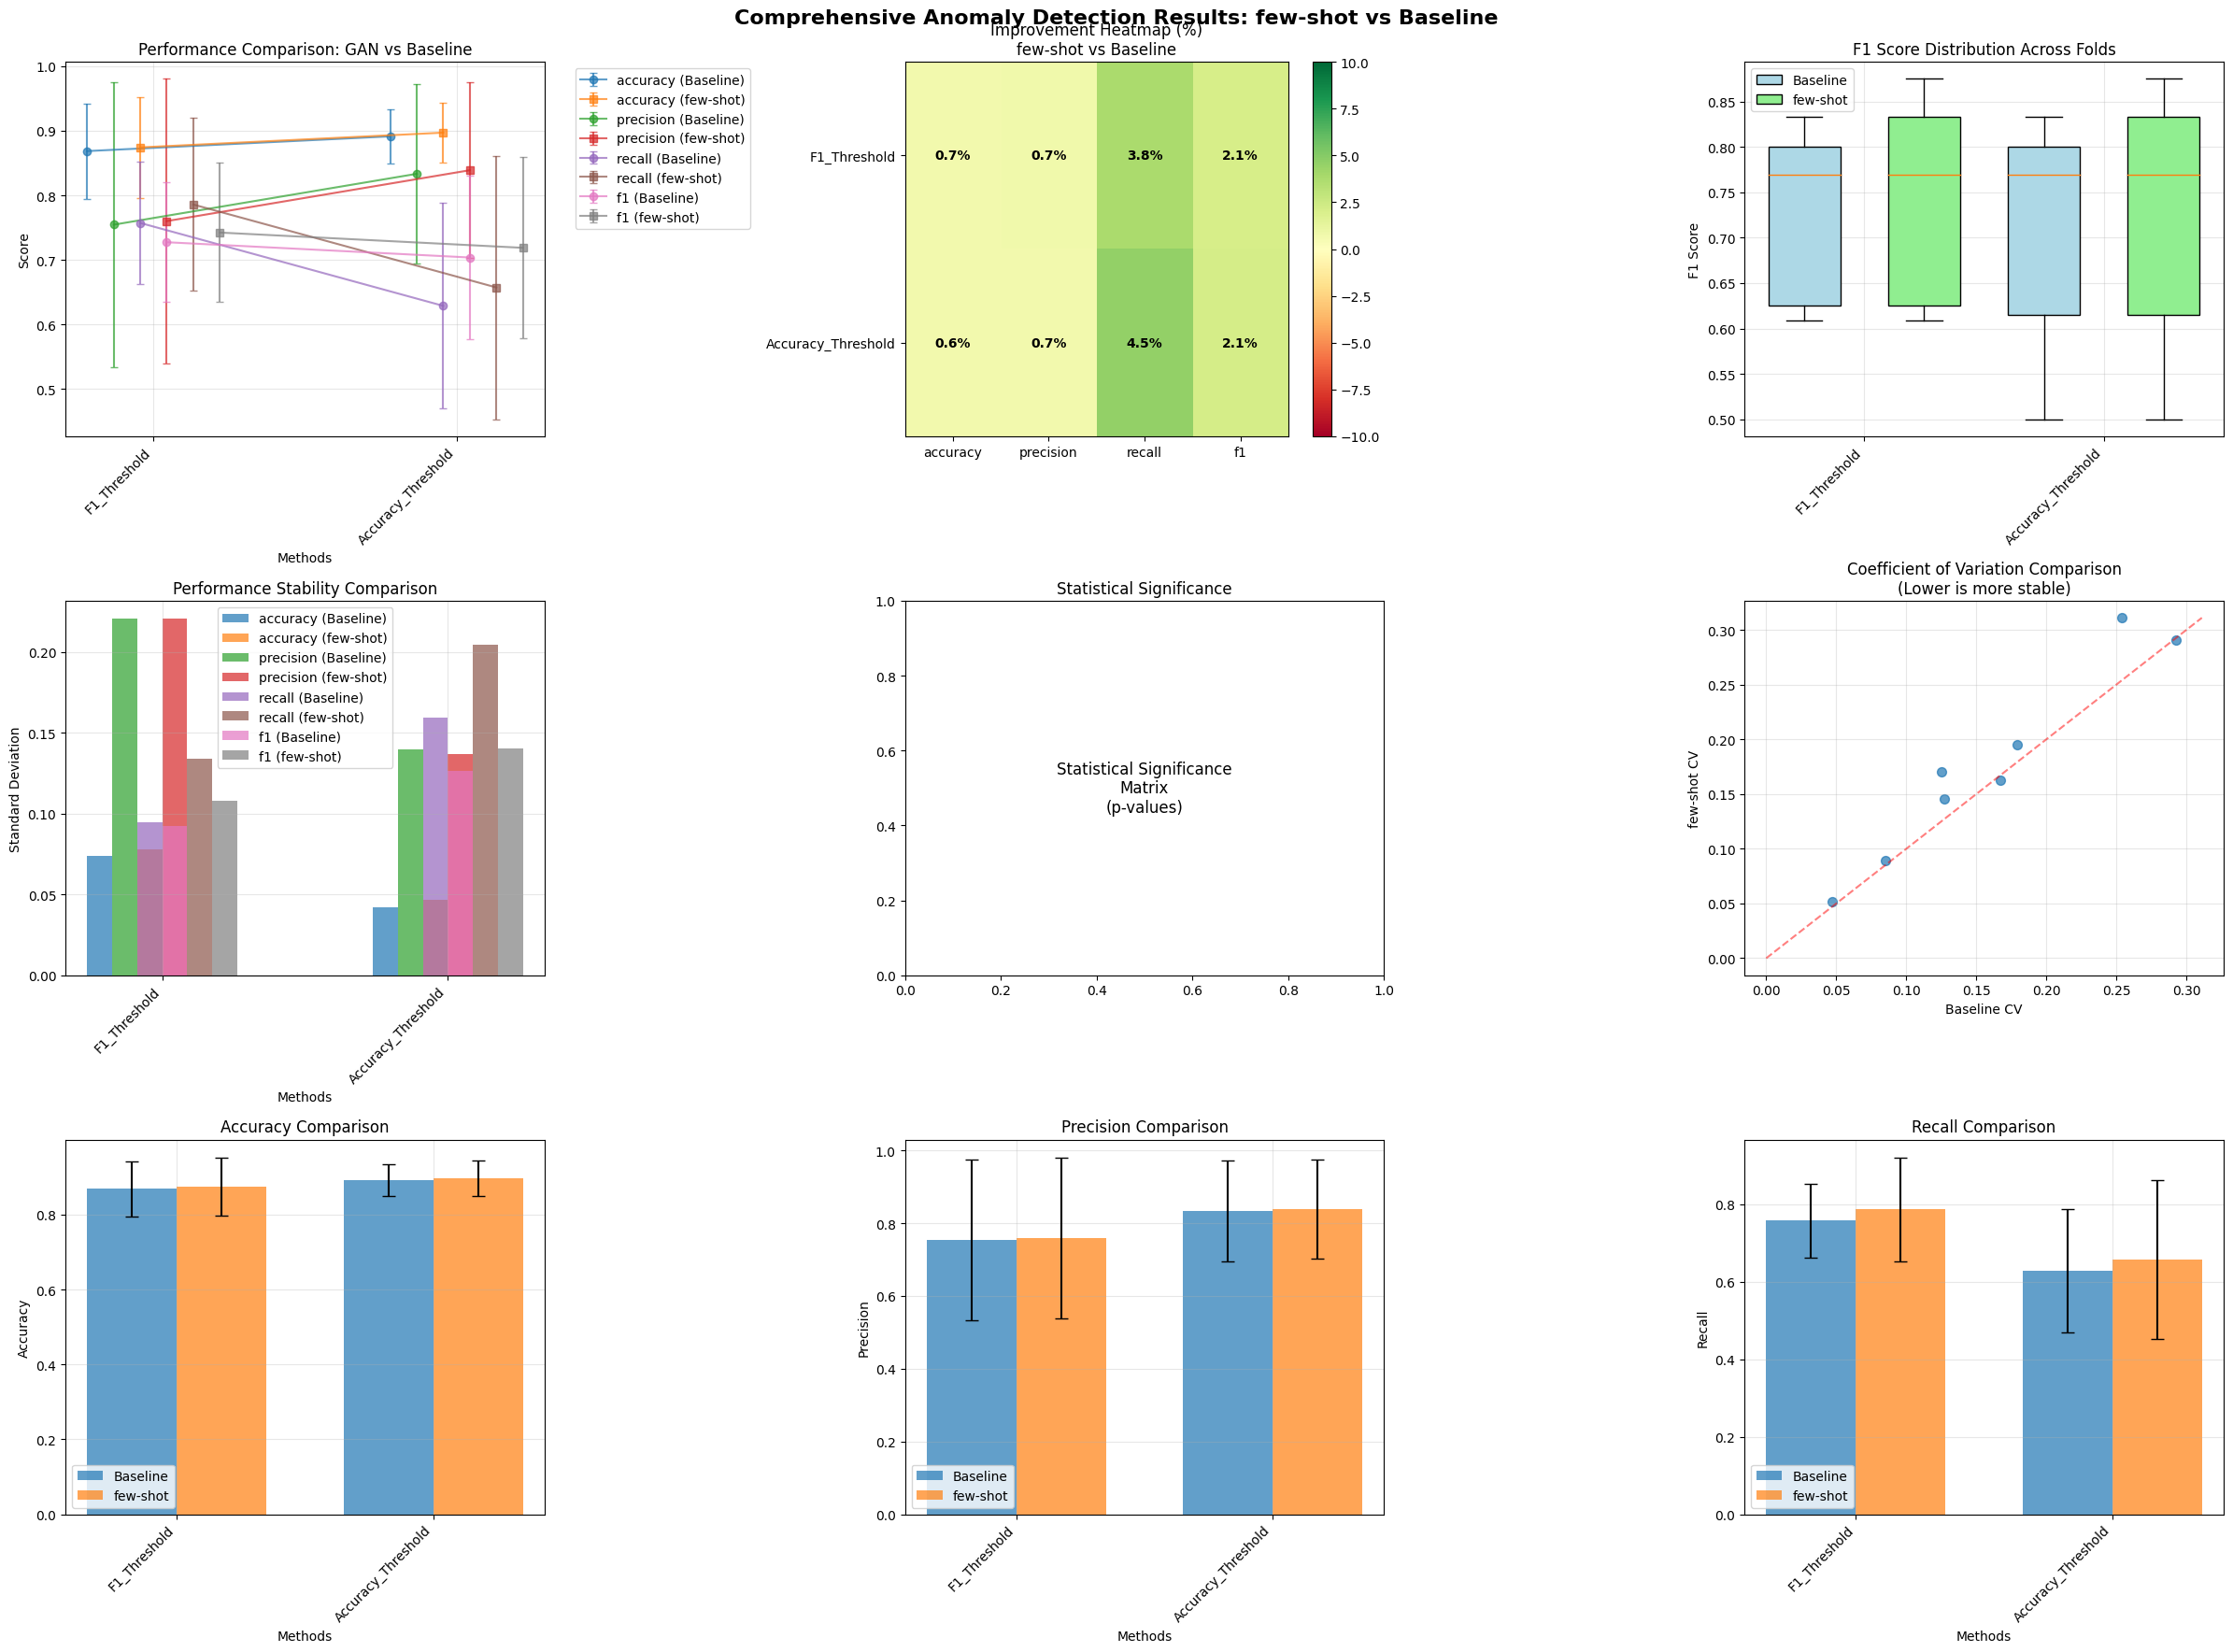


ENHANCED ANOMALY DETECTION RECOMMENDATIONS (few-shot)

🏆 BEST METHODS WITH few-shot:
   • Best F1 Score: F1_Threshold (0.7423 ± 0.1079)
   • Most Stable: F1_Threshold (CV = 0.1454)

📈 few-shot EFFECTIVENESS:
   • F1_Threshold: 100% metrics improved, 0% significantly
   • Accuracy_Threshold: 100% metrics improved, 0% significantly

🎯 few-shot OVERALL EFFECTIVENESS: Not Effective
   • 0/8 comparisons show significant improvement
   • Success Rate: 0.0%

📊 METHOD-SPECIFIC INSIGHTS:
   • F1_Threshold          : Performance Boost
   • Accuracy_Threshold    : Performance Boost

🎯 FINAL RECOMMENDATIONS:
   ❌ few-shot data augmentation shows LIMITED benefit
   • Consider baseline methods or alternative GAN architectures
   • Current success rate: 0.0%

💡 DEPLOYMENT STRATEGY:
   • Stick with baseline methods for now
   • Investigate alternative data augmentation strategies
   • Consider ensemble methods combining multiple approaches



({'F1_Threshold': {'accuracy': {'mean': 0.8742857142857143,
    'std': 0.07793246683991915,
    'min': 0.7428571428571429,
    'max': 0.9428571428571428,
    'median': 0.9142857142857143,
    'values': [0.9428571428571428,
     0.8285714285714286,
     0.9428571428571428,
     0.9142857142857143,
     0.7428571428571429]},
   'precision': {'mean': 0.76,
    'std': 0.22061642037317078,
    'min': 0.4666666666666667,
    'max': 1.0,
    'median': 0.7777777777777778,
    'values': [0.7777777777777778,
     0.5555555555555556,
     1.0,
     1.0,
     0.4666666666666667]},
   'recall': {'mean': 0.7857142857142858,
    'std': 0.1341070239679899,
    'min': 0.625,
    'max': 1.0,
    'median': 0.7142857142857143,
    'values': [1.0, 0.7142857142857143, 0.7142857142857143, 0.625, 0.875]},
   'f1': {'mean': 0.7422519509476031,
    'std': 0.1079175836679228,
    'min': 0.608695652173913,
    'max': 0.8750000000000001,
    'median': 0.7692307692307693,
    'values': [0.8750000000000001,
     0.6

In [6]:
run_comprehensive_cross_validation_experiment(X_test_normal, X_test_faulty, device, generated_data, batch_size=32, gan_type="few-shot")